In [90]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne 
import scipy.signal as sp_signal
from sktime.libs.vmdpy import VMD
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import periodogram
from sklearn.preprocessing import MinMaxScaler
from pymultifracs.viz import plot_psd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts")))
from simulation import generate_synthetic_neural_signal
from decomposition import run_all_decompositions
from plotting import plot_signal_and_modes
from features import compute_features_from_modes_and_save
from mfa_utils import compute_mfa, plot_mfa, plot_psd, analyze_signal_and_modes
from evaluation import summarize_decomposition_results
from pymultifracs import mfa, wavelet_analysis


In [16]:
%matplotlib inline

## 1. Signal extraction

In [91]:
#raw = mne.io.read_raw_fif("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif")
raw = mne.io.read_raw_fif("../data/real/sub-01_ses-01_task-rest_proc-filt_raw.fif", preload=True)




Opening raw data file ../data/real/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.
Reading 0 ... 82499  =      0.000 ...   329.996 secs...


## 2. Signal exploration

In [20]:
raw

<Raw | sub-01_ses-01_task-rest_proc-filt_raw.fif, 356 x 82500 (330.0 s), ~224.6 MiB, data loaded>

Using matplotlib as 2D backend.


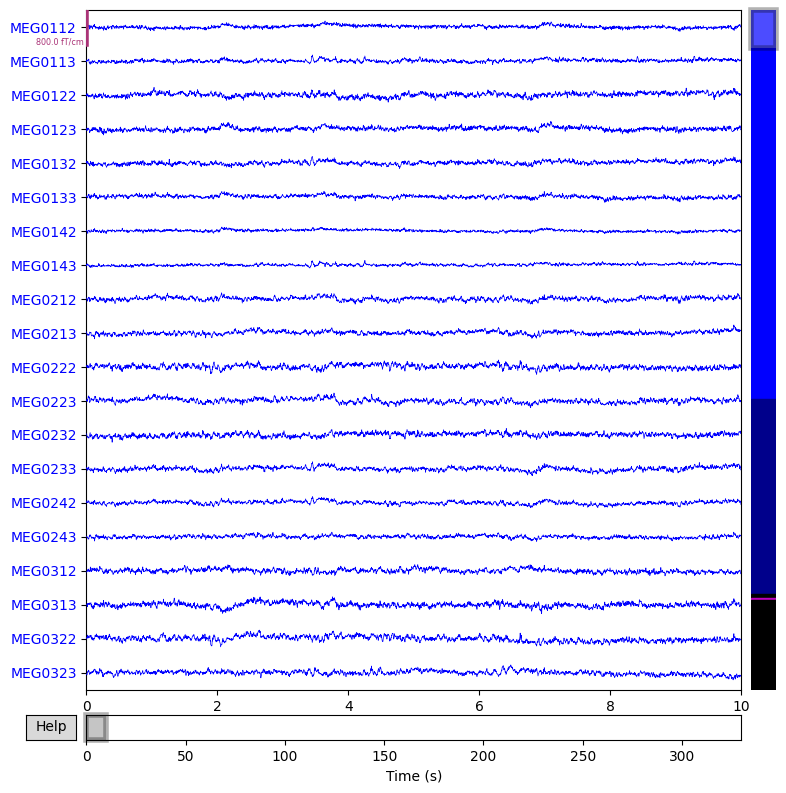

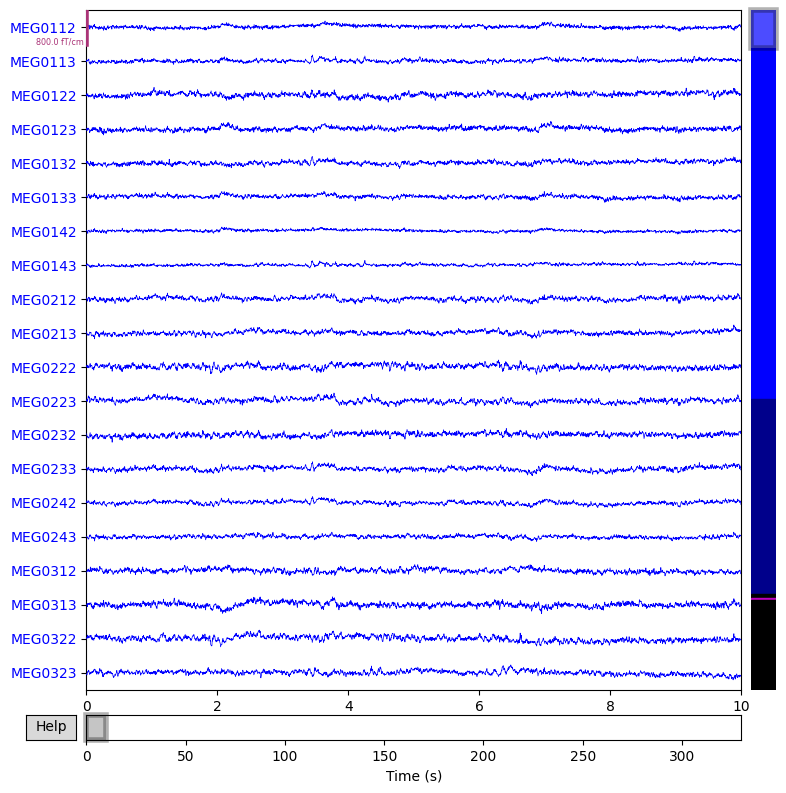

In [21]:
raw.plot()

In [22]:
# Make a copy and pick MEG channels by type
raw_meg = raw.copy().pick('meg')  # Magnetometers and gradiometers

# Apply filtering
#raw_meg_filtered = raw_meg.filter(l_freq=8.0, h_freq=12.0)

In [23]:
data_matrix = raw_meg.get_data()

In [24]:
print(data_matrix.shape)
type(data_matrix)

(306, 82500)


numpy.ndarray

In [25]:
sfreq = raw.info["sfreq"]
sfreq

250.0

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/volatile/home/sb283337/miniconda3/envs/mfa-internship/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


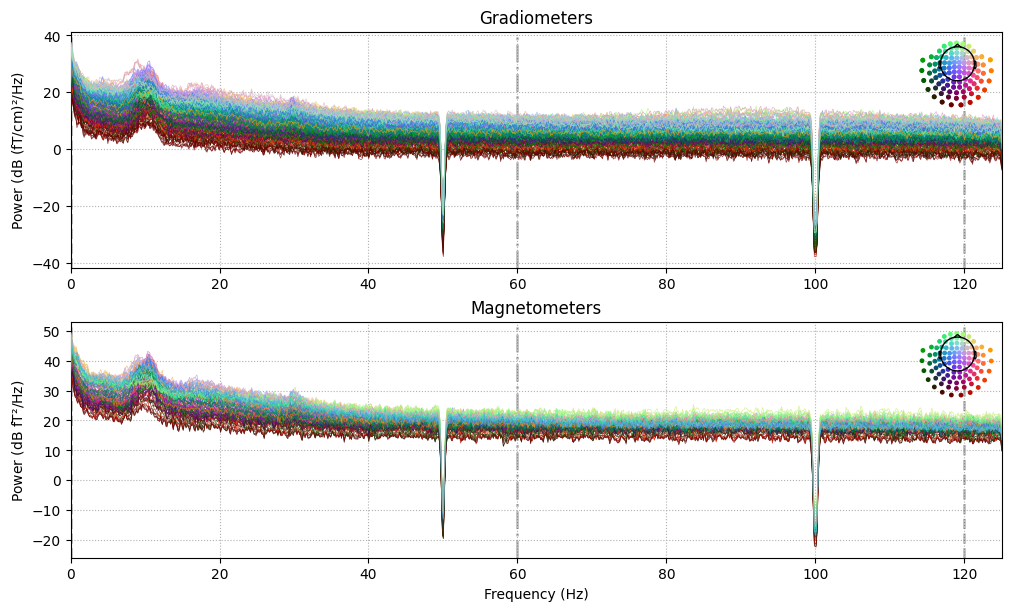

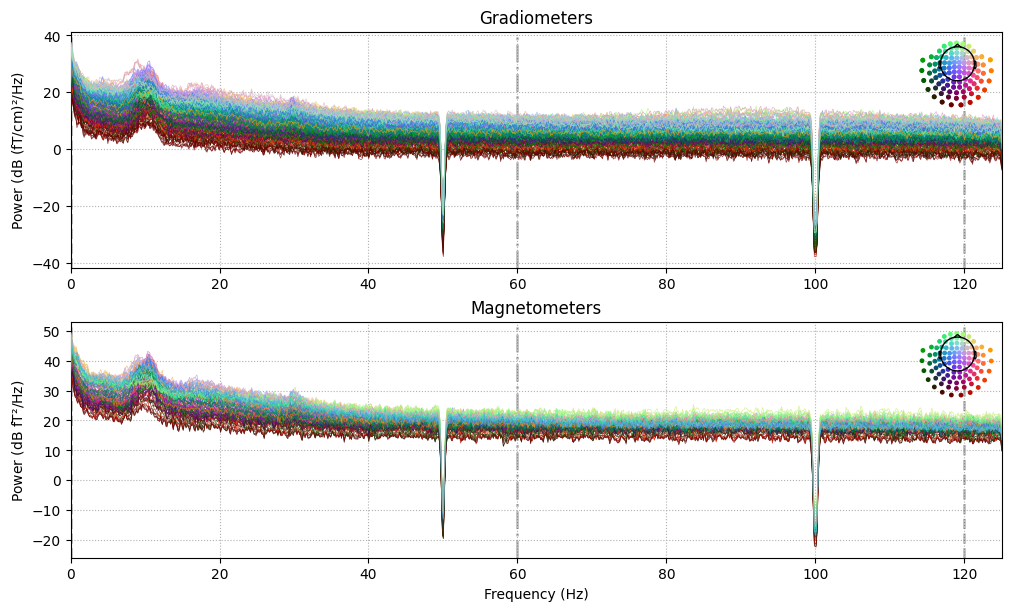

In [26]:
raw.plot_psd()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/volatile/home/sb283337/miniconda3/envs/mfa-internship/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


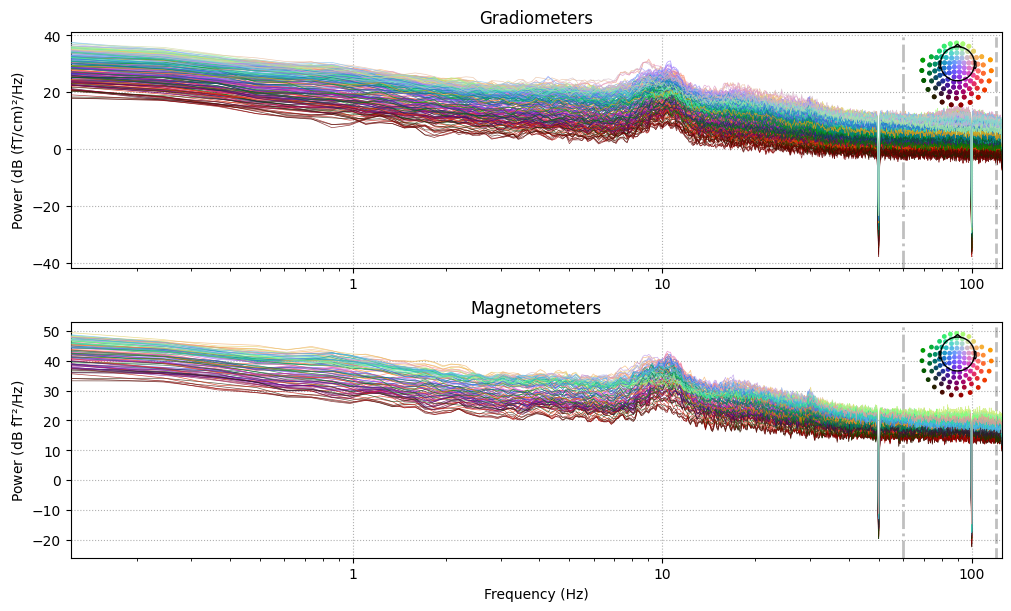

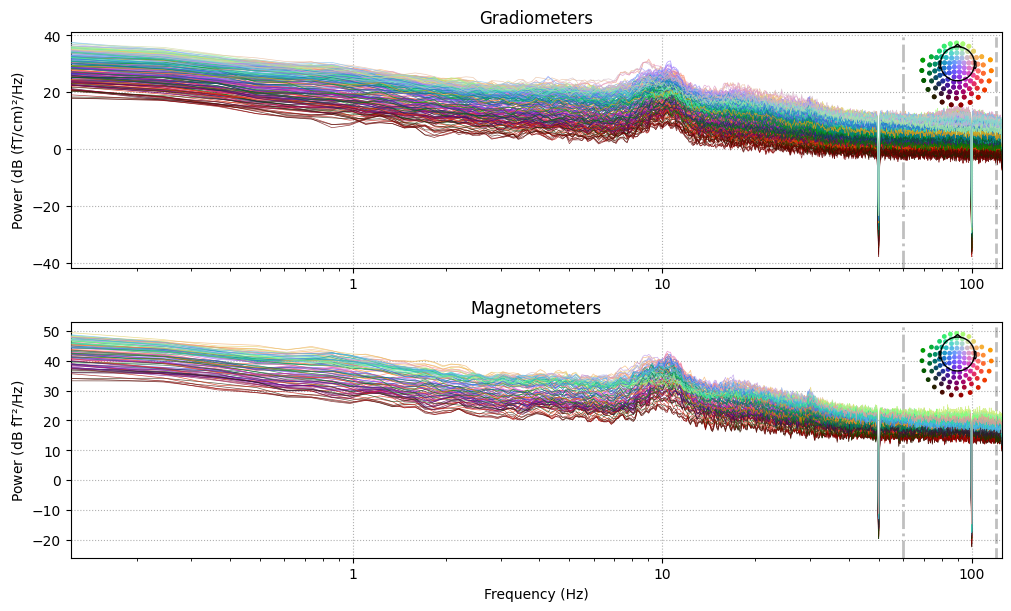

In [27]:
raw.plot_psd(xscale="log")

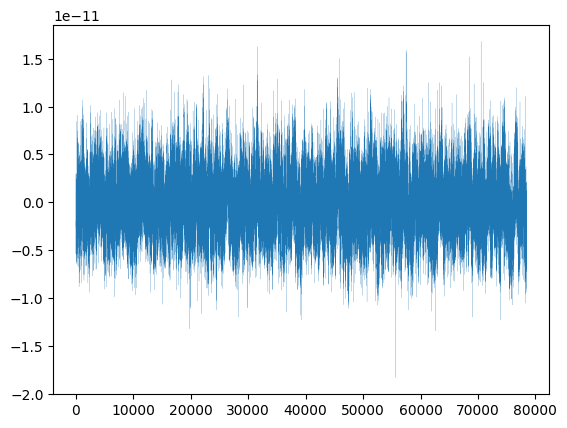

In [28]:
X = data_matrix[2, 2000:-2000]
plt.plot(X, lw=.1)
plt.show()

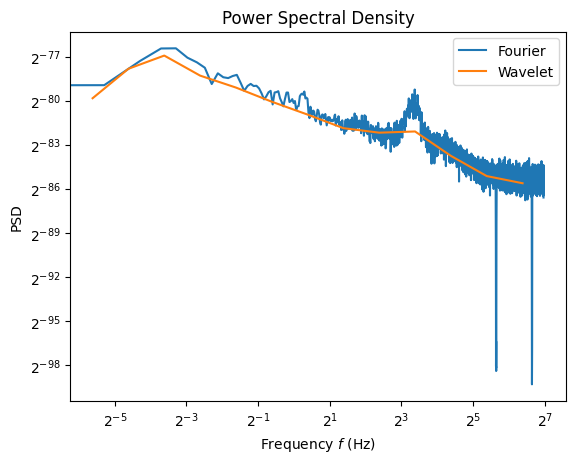

In [29]:
from pymultifracs.viz import plot_psd
plot_psd(X, fs=sfreq)

In [30]:
WT = wavelet_analysis(X, 'db6').integrate(1)

In [31]:
WT.freq2scale(2.0, sfreq)
WT.scale2freq(9, sfreq)

np.float64(0.35511363636363635)

In [32]:
dwt = mfa(WT, [(6, 11)])

In [72]:
dwt.structure.plot()

NameError: name 'dwt' is not defined

In [34]:
H = float(dwt.structure.H.squeeze())

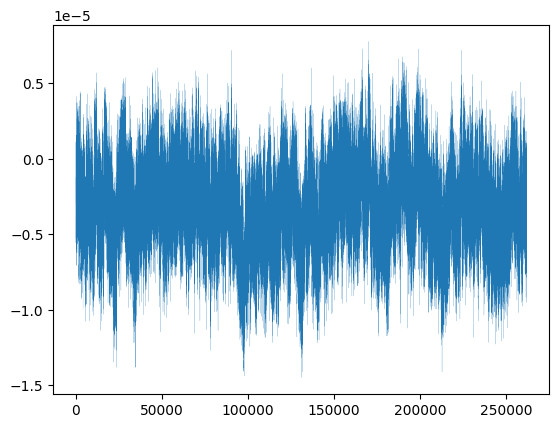

In [35]:
from pymultifracs.simul import fbm
Y = fbm(shape=(2 ** 18), H=H)
plt.plot(np.diff(Y), lw=.1)

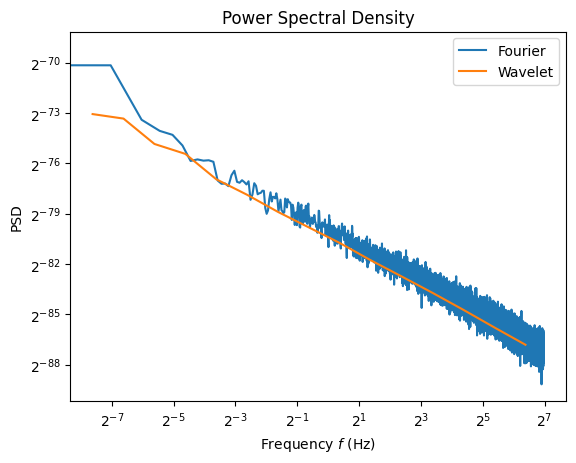

In [36]:
from pymultifracs.viz import plot_psd
plot_psd(np.diff(Y) / np.diff(Y).std() * X.std(), sfreq)


(1.6155871338926322e-27, 1.0587911840678754e-22)

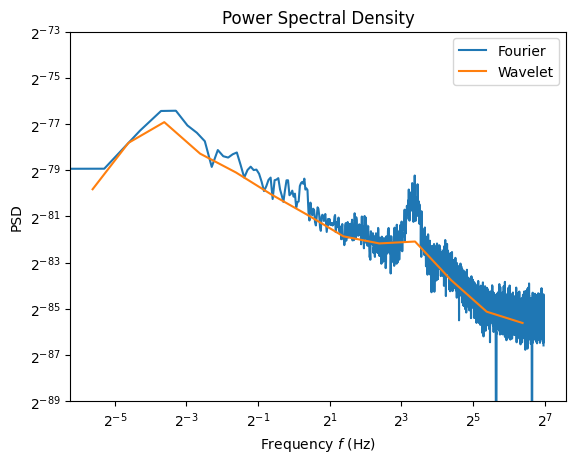

In [37]:
plot_psd(X, sfreq)
plt.ylim(2**-89,2**-73)

## 3. Signal decomposition

### Set Parameters:

In [197]:
# Load MEG data
raw_meg = raw.copy().pick('meg')
data_matrix = raw_meg.get_data()  # (n_channels, n_times)

# Parameters (from your code)
fs = 250  # Sampling frequency
duration = 300.0  # Duration to plot (seconds)
max_points = 1000
methods = ["VMD"]

max_imfs = 5
max_modes = 5
Nmodes = 5

best_vmd_params = {
    'meg': {'vmd_alpha': 200, 'vmd_tau': 0.5, 'vmd_DC': 1, 'vmd_init': 0, 'vmd_tol': 1e-7, '': 5},
}

output_base = "../results/real/"

n_channels_to_process = 306  # First 10 magnetometers

### Run the Decompositions:

In [95]:
scale_factor = 1e11

for ch_idx in range(n_channels_to_process):
    signal = data_matrix[ch_idx, :]
    signal_rescaled = signal * scale_factor
    name = f"meg_channel_{ch_idx}"

    print(f"--- Decomposition for: {name} ---")
    output_dir = os.path.join(output_base, name)
    os.makedirs(output_dir, exist_ok=True)

    params = best_vmd_params.get('meg', {})

    modes_dict = run_all_decompositions(
        signal_in=signal_rescaled,
        methods=methods,
        Fs=fs,
        Nmodes=params.get('Nmodes', 3),
        MaxEmdIMF=max_imfs,
        MaxVmdModes=max_modes,
        vmd_alpha=params.get('vmd_alpha', 1),
        vmd_tau=params.get('vmd_tau', 0),
        vmd_DC=params.get('vmd_DC', 1),
        vmd_init=params.get('vmd_init', 0),
        vmd_tol=params.get('vmd_tol', 1e-1),
        return_modes=True
    )

    # Rescale modes back to original scale
    for method in modes_dict:
        modes_dict[method] = modes_dict[method] / scale_factor

    for method in methods:
        method_dir = os.path.join(output_dir, method)
        os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)

        np.save(os.path.join(method_dir, "modes", f"{name}_modes.npy"), modes_dict[method])

        print(f"Saved modes for {method} of {name}")


--- Decomposition for: meg_channel_0 ---
VMD decomposition done in 0.18 seconds.
Saved modes for VMD of meg_channel_0
--- Decomposition for: meg_channel_1 ---
VMD decomposition done in 6.53 seconds.
Saved modes for VMD of meg_channel_1
--- Decomposition for: meg_channel_2 ---
VMD decomposition done in 6.35 seconds.
Saved modes for VMD of meg_channel_2
--- Decomposition for: meg_channel_3 ---
VMD decomposition done in 0.17 seconds.
Saved modes for VMD of meg_channel_3
--- Decomposition for: meg_channel_4 ---
VMD decomposition done in 9.78 seconds.
Saved modes for VMD of meg_channel_4
--- Decomposition for: meg_channel_5 ---
VMD decomposition done in 10.44 seconds.
Saved modes for VMD of meg_channel_5
--- Decomposition for: meg_channel_6 ---
VMD decomposition done in 0.22 seconds.
Saved modes for VMD of meg_channel_6
--- Decomposition for: meg_channel_7 ---
VMD decomposition done in 8.12 seconds.
Saved modes for VMD of meg_channel_7
--- Decomposition for: meg_channel_8 ---
VMD decomposit

In [179]:
# Once modes saved, run feature extraction on MEG channels:
for ch_idx in range(n_channels_to_process):
    name = f"meg_channel_{ch_idx}"
    output_dir = os.path.join(output_base, name)
    
    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_modes.npy")
        features_path = os.path.join(output_dir, method, "features", f"{name}_features.csv")

        compute_features_from_modes_and_save(modes_path, features_path, fs)
        print(f"Features saved for {method} of {name}")


Features saved to ../results/real/meg_channel_0/VMD/features/meg_channel_0_features.csv
Features saved for VMD of meg_channel_0
Features saved to ../results/real/meg_channel_1/VMD/features/meg_channel_1_features.csv
Features saved for VMD of meg_channel_1
Features saved to ../results/real/meg_channel_2/VMD/features/meg_channel_2_features.csv
Features saved for VMD of meg_channel_2
Features saved to ../results/real/meg_channel_3/VMD/features/meg_channel_3_features.csv
Features saved for VMD of meg_channel_3
Features saved to ../results/real/meg_channel_4/VMD/features/meg_channel_4_features.csv
Features saved for VMD of meg_channel_4
Features saved to ../results/real/meg_channel_5/VMD/features/meg_channel_5_features.csv
Features saved for VMD of meg_channel_5
Features saved to ../results/real/meg_channel_6/VMD/features/meg_channel_6_features.csv
Features saved for VMD of meg_channel_6
Features saved to ../results/real/meg_channel_7/VMD/features/meg_channel_7_features.csv
Features saved f

In [ ]:
# Generate plots for MEG channels:
for ch_idx in range(n_channels_to_process):
    signal = data_matrix[ch_idx, :]
    name = f"meg_channel_{ch_idx}"
    output_dir = os.path.join(output_base, name)

    for method in methods:
        modes_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
        modes = np.load(modes_path)

        plot_signal_and_modes(
            x=signal,
            sfreq=fs,
            modes=modes,
            method=method,
            ch=ch_idx,
            output_dir=output_base,
            duration=duration,
            max_points=max_points,
            spectrum_method='windowed_fft'  # or 'psd' or 'fft'
        )
        print(f"Plots saved for {method} of {name}")

### Summarize the Results:

In [231]:
all_corrs = []

for ch in range(n_channels_to_process):
    name = f"meg_channel_{ch}"
    mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")

    if not os.path.exists(mode_path):
        print(f"❌ Missing: {name}")
        continue

    modes = np.load(mode_path)

    # Always transpose to shape (T, Nmodes) for correlation across time
    if modes.shape[0] == Nmodes:
        modes = modes.T  # Now shape = (T, Nmodes)

    if modes.shape[1] != Nmodes:
        print(f"⚠️ Skipped {name}, unexpected shape: {modes.shape}")
        continue

    corr = np.corrcoef(modes.T)  # Compute correlation between modes (shape: 6x6)
    all_corrs.append(corr)

# === Aveage correlation matrices ===

avg_corr = np.mean(all_corrs, axis=0)


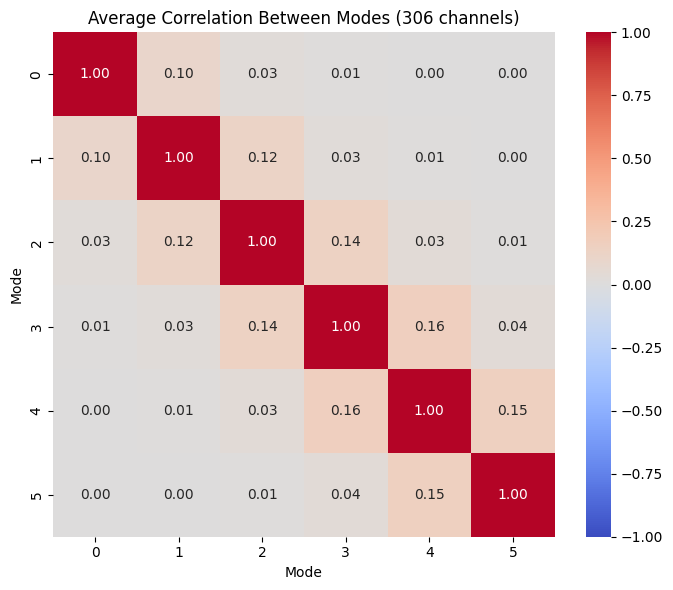

In [ ]:
# === Plot ===
plt.figure(figsize=(7, 6))
sns.heatmap(avg_corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average Correlation Between Modes (306 channels)")
plt.xlabel("Mode")
plt.ylabel("Mode")
plt.tight_layout()
plt.show()

In [235]:
# ---- Band classifier ----
def get_band(freq):
    if 1 <= freq < 4:
        return "Delta"
    elif 4 <= freq < 8:
        return "Theta"
    elif 8 <= freq < 13:
        return "Alpha"
    elif 13 <= freq < 30:
        return "Beta"
    elif 30 <= freq < 70:
        return "Gamma"
    elif freq >= 70:
        return "High Gamma"
    else:
        return "NotClassified"

# ---- Rebuild full DataFrame ----
all_rows = []
for ch in range(n_channels_to_process):
    name = f"meg_channel_{ch}"
    feat_path = os.path.join(output_base, name, method, "features", f"{name}_features.csv")
    mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
    
    if not os.path.exists(feat_path) or not os.path.exists(mode_path):
        continue

    df = pd.read_csv(feat_path)
    modes = np.load(mode_path)
    
    for mode_idx in range(Nmodes):
        row = [ch, mode_idx]        
        features = [df[f"{col}{mode_idx}"].iloc[0] for col in ["AM", "BM", "ent", "pow", "Cent", "Ppeak", "Pfreq", "skew", "kurt", "Hmob", "Hcomp"]]
        peak_freq = features[6]  # Ppeak
        band = get_band(peak_freq)
        
        all_rows.append(row + features + [peak_freq, band])

# ---- Final DataFrame ----
columns = ["channel", "mode", "AM", "BM", "ent", "pow", "Cent", "Ppeak", "Pfreq", "skew", "kurt", "Hmob", "Hcomp", "peak_freq", "band"]
features_df = pd.DataFrame(all_rows, columns=columns)

In [236]:
features_df

,channel,mode,AM,BM,ent,pow,Cent,Ppeak,Pfreq,skew,kurt,Hmob,Hcomp,peak_freq,band
0,0,0,1.298168e+16,2.171850e+07,3.695105,0.000244,1.225309,0.250691,0.244141,-0.400528,1.129028,0.044575,10.319955,0.244141,NotClassified
1,0,1,3.374272e+16,2.627422e+08,5.375583,0.000071,11.160331,0.069893,10.253906,-0.004480,0.405132,0.290161,1.223980,10.253906,Alpha
2,0,2,1.329444e+17,7.415270e+08,6.711793,0.000022,31.561046,0.017768,29.785156,-0.002397,0.127830,0.783781,1.070851,29.785156,Beta
3,0,3,1.884065e+17,1.398895e+09,6.906759,0.000019,59.537771,0.014053,60.302734,0.000016,0.100989,1.361271,1.018657,60.302734,Gamma
4,0,4,1.778668e+17,2.025760e+09,6.839655,0.000020,86.194034,0.015560,87.646484,-0.000036,-0.053914,1.762013,1.004322,87.646484,High Gamma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831,305,1,1.915255e+15,2.652691e+08,5.543303,0.000058,11.276692,0.052380,10.986328,0.061165,0.959115,0.293747,1.229574,10.986328,Alpha
1832,305,2,7.259415e+15,7.500471e+08,6.721031,0.000021,31.965962,0.017666,30.517578,0.000996,0.006907,0.792935,1.068996,30.517578,Gamma
1833,305,3,9.796820e+15,1.381195e+09,6.857290,0.000020,58.850451,0.015363,59.326172,0.000816,0.028034,1.348999,1.018109,59.326172,Gamma
1834,305,4,1.096314e+16,2.002707e+09,6.899653,0.000019,85.337282,0.015498,83.007812,-0.023265,0.004420,1.751640,1.004855,83.007812,High Gamma


In [237]:
features_df["band"].value_counts()

band
High Gamma       611
Gamma            420
NotClassified    306
Alpha            306
Beta             193
Name: count, dtype: int64

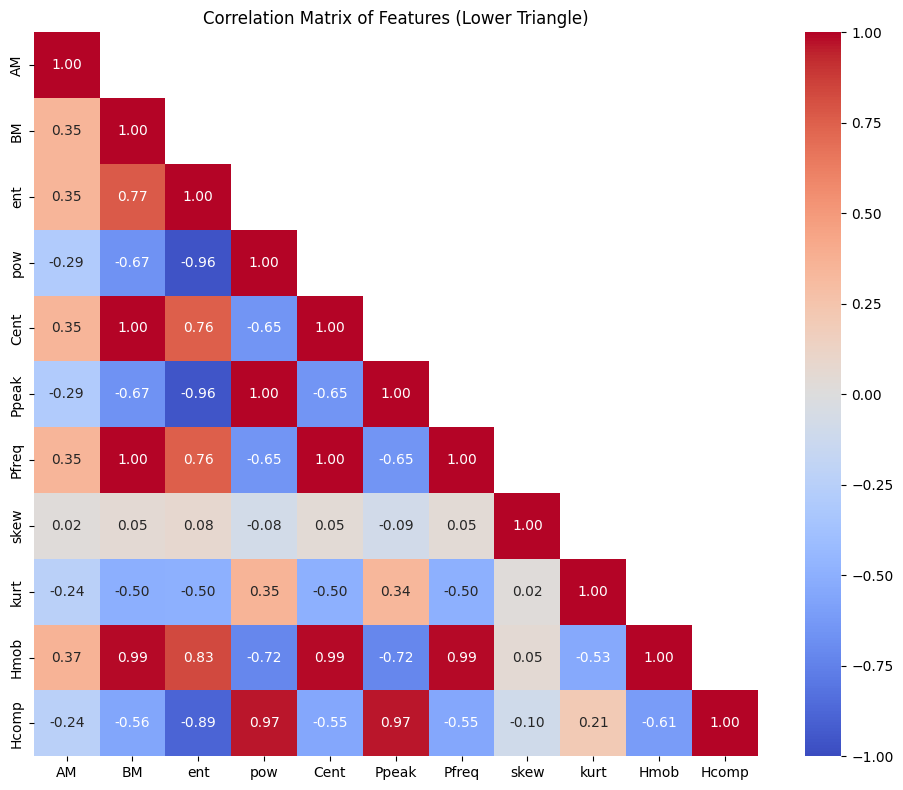

In [240]:
# Compute correlation matrix
corr = features_df.drop(columns=["channel", "mode", "peak_freq", "band"]).corr()

# Create mask for the upper triangle (excluding diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            vmin=-1, vmax=1, 
            annot=True, fmt=".2f", 
            cmap="coolwarm", 
            mask=mask, square=True)

plt.title("Correlation Matrix of Features (Lower Triangle)")
plt.tight_layout()
plt.show()


In [241]:
# PCA (2D) + Add PC1 and PC2
X = features_df.drop(columns=["channel", "mode", "peak_freq", "band"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
proj = pca.fit_transform(X_scaled)
features_df["PC1"] = proj[:, 0]
features_df["PC2"] = proj[:, 1]

In [279]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4,init='k-means++',   random_state=42, n_init=100)
features_df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

In [273]:
# DBSCAN Clustering (Optional Tuning Needed)
dbscan = DBSCAN(eps=0.85, min_samples=50)
features_df["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

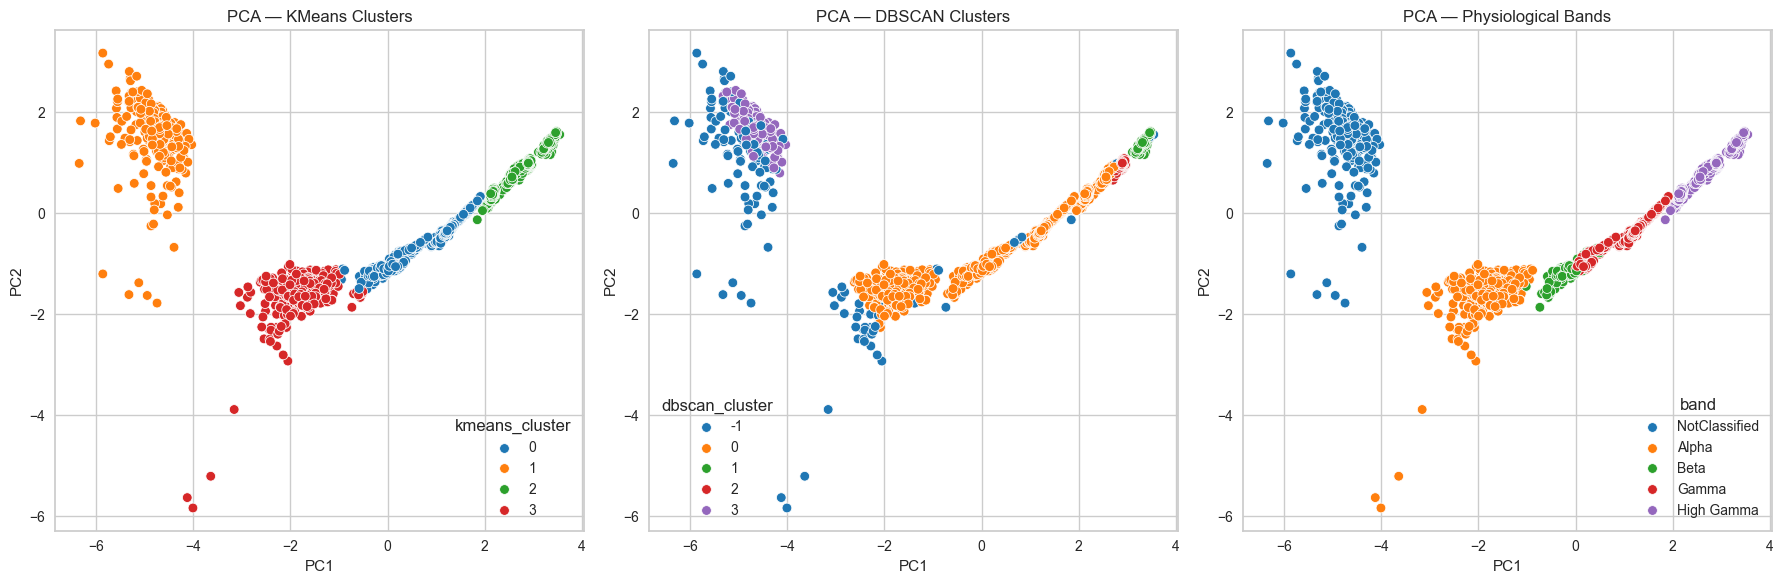

In [280]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=features_df, x="PC1", y="PC2", hue="kmeans_cluster", palette="tab10", ax=axs[0])
axs[0].set_title("PCA — KMeans Clusters")

sns.scatterplot(data=features_df, x="PC1", y="PC2", hue="dbscan_cluster", palette="tab10", ax=axs[1])
axs[1].set_title("PCA — DBSCAN Clusters")

sns.scatterplot(data=features_df, x="PC1", y="PC2", hue="band", palette="tab10", ax=axs[2])
axs[2].set_title("PCA — Physiological Bands")

for ax in axs:
    ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# KMeans vs. band
cont_kmeans = pd.crosstab(features_df["kmeans_cluster"], features_df["band"])
print("KMeans vs Band:\n", cont_kmeans)

# DBSCAN vs. band
cont_dbscan = pd.crosstab(features_df["dbscan_cluster"], features_df["band"])
print("\nDBSCAN vs Band:\n", cont_dbscan)

KMeans vs Band:
 band            Alpha  Beta  Gamma  High Gamma  NotClassified
kmeans_cluster                                               
0                   0     0    111         100              0
1                 286     2      0           0              0
2                   0     0    204         205              0
3                   0     0      0           0            306
4                  20   191    105           0              0

DBSCAN vs Band:
 band            Alpha  Beta  Gamma  High Gamma  NotClassified
dbscan_cluster                                               
-1                  4     0      0           0             14
 0                  0     0      0           0            292
 1                302   193    420         305              0


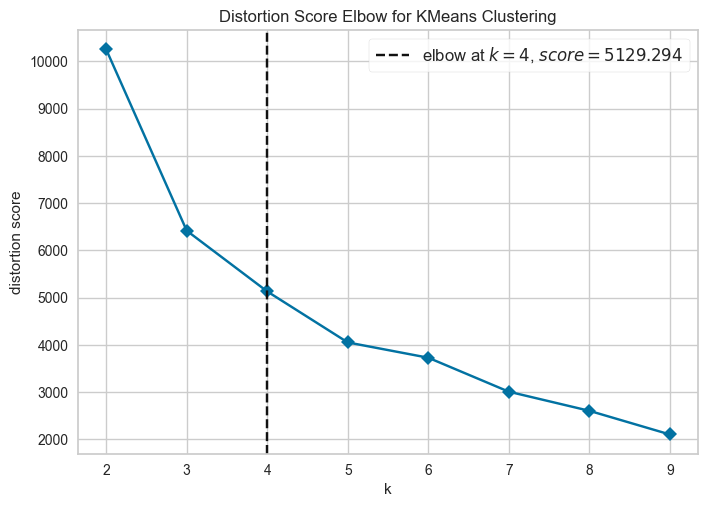

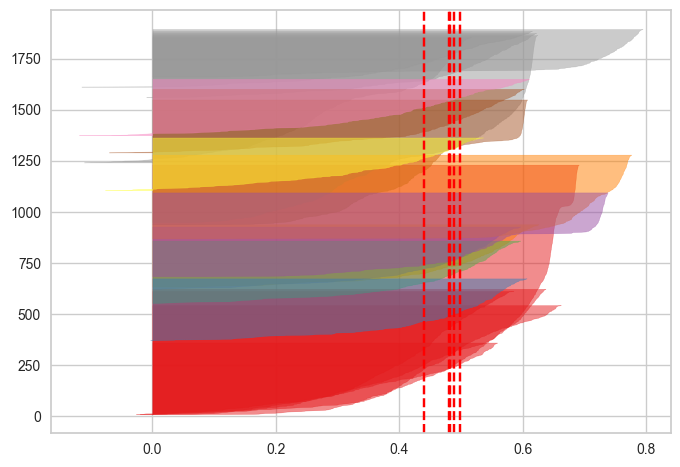

In [281]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# --- Elbow method ---
model = KMeans(init='k-means++', random_state=42)
elbow = KElbowVisualizer(model, k=(2, 10), metric='distortion', timings=False)
elbow.fit(X_scaled)
elbow.show()

# --- Silhouette method ---
# Use the best K found by elbow or test multiple Ks
for k in range(2, 7):  # You can change this range
    model = KMeans(n_clusters=k, init='k-means++', random_state=42)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(X_scaled)


In [99]:
report_df


,Method,Signal,Mode Index,Peak Frequency (Hz),Reconstruction MSE (Full),Reconstruction MSE (First N Modes),Number of Extracted Modes,AM,BM,Entropy,Centroid,Power Spectrum Sum,Skewness,Kurtosis,Hjorth Mobility,Hjorth Complexity
0,VMD,meg_channel_0,0,0.118182,8.764379e-08,8.764379e-08,5,1.311368e-13,2.280885e-21,3.733832,20.991215,9.120297e-24,-0.116878,0.313830,0.752446,2.173572
1,VMD,meg_channel_0,1,121.778788,8.764379e-08,8.764379e-08,5,6.147237e-15,4.886174e-24,3.182946,98.803770,1.954469e-26,0.001847,0.106147,1.850124,1.020236
2,VMD,meg_channel_0,2,121.778788,8.764379e-08,8.764379e-08,5,8.869690e-16,1.016807e-25,3.275328,108.781914,4.067229e-28,0.000320,0.079110,1.934534,1.004880
3,VMD,meg_channel_0,3,121.778788,8.764379e-08,8.764379e-08,5,1.446952e-16,2.705941e-27,3.379112,113.322122,1.082376e-29,0.000063,0.059442,1.963737,1.001803
4,VMD,meg_channel_0,4,121.778788,8.764379e-08,8.764379e-08,5,2.497479e-17,8.063682e-29,3.476787,115.911198,3.225473e-31,0.000011,0.044237,1.977241,1.000801
5,VMD,meg_channel_1,0,0.290909,2.688453e-06,2.688453e-06,5,2.112881e-12,5.966185e-19,3.889936,2.900904,2.386437e-21,0.383522,0.506791,0.146049,3.354223
6,VMD,meg_channel_1,1,91.003030,2.688453e-06,2.688453e-06,5,8.357390e-13,9.040434e-20,3.535040,84.128565,3.616173e-22,0.010763,0.016756,1.719795,1.026743
7,VMD,meg_channel_1,2,37.509091,2.688453e-06,2.688453e-06,5,5.327096e-13,3.679321e-20,3.682015,43.696115,1.471728e-22,0.003233,0.040911,1.063212,1.130608
8,VMD,meg_channel_1,3,121.193939,2.688453e-06,2.688453e-06,5,3.093643e-13,1.240917e-20,3.751265,117.067160,4.963669e-23,0.000968,0.059822,1.982778,1.001173
9,VMD,meg_channel_1,4,21.421212,2.688453e-06,2.688453e-06,5,8.598158e-14,9.711997e-22,3.697744,22.256509,3.884799e-24,-0.031586,0.196191,0.596429,1.461094


In [ ]:
# # Select relevant features for radar plot
# radar_features = [
#     "Reconstruction MSE (First N Modes)",
#     "Hjorth Mobility",
#     "Hjorth Complexity",
#     "Power Spectrum Sum",
#     "Entropy"
# ]

# # Copy df to avoid modifying original
# df_plot = report_df.copy()

# # Normalize selected features to [0,1]
# df_plot["Power Spectrum Sum"] = np.log10(report_df["Power Spectrum Sum"] + 1e-10)
# scaler = MinMaxScaler()
# df_plot[radar_features] = scaler.fit_transform(df_plot[radar_features])

# # Invert MSE so higher is better (1 - normalized MSE)
# #df_plot["Reconstruction MSE (First N Modes)"] = 1 - df_plot["Reconstruction MSE (First N Modes)"]


# # Plot setup
# signals = df_plot["Signal"].unique()
# angles = np.linspace(0, 2 * np.pi, len(radar_features), endpoint=False).tolist()
# angles += angles[:1]  # close the loop

# colors = {
#     "EMD": "#FF69B4",   # pink
#     "VMD": "#FFA500"    # orange
# }

# fig, axs = plt.subplots(1, len(signals), figsize=(18, 6), subplot_kw=dict(polar=True))

# for i, signal in enumerate(signals):
#     ax = axs[i]
#     for method in ["VMD"]:
#         subset = df_plot[(df_plot["Signal"] == signal) & (df_plot["Method"] == method)]
#         if not subset.empty:
#             values = subset[radar_features].mean().tolist()
#             values += values[:1]  # close the radar plot
#             ax.plot(angles, values, label=method, color=colors[method], linewidth=2)
#             ax.fill(angles, values, color=colors[method], alpha=0.25)

#     ax.set_title(signal, size=14, pad=20)
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(radar_features, fontsize=10)
#     ax.set_yticklabels([])
#     ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

# plt.suptitle("Normalized Radar Comparison: EMD vs VMD", fontsize=16)
# plt.tight_layout()
# plt.savefig("radar_horizontal_emd_vmd.png", dpi=300)
# plt.show()

Processing signal: meg_channel_0


<Figure size 800x400 with 0 Axes>

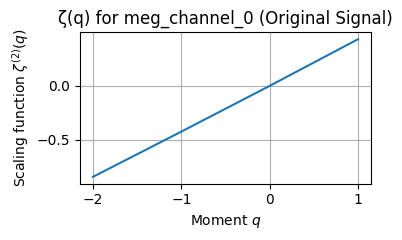

<Figure size 800x400 with 0 Axes>

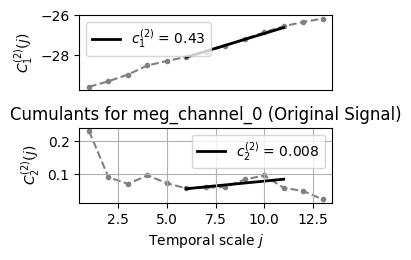

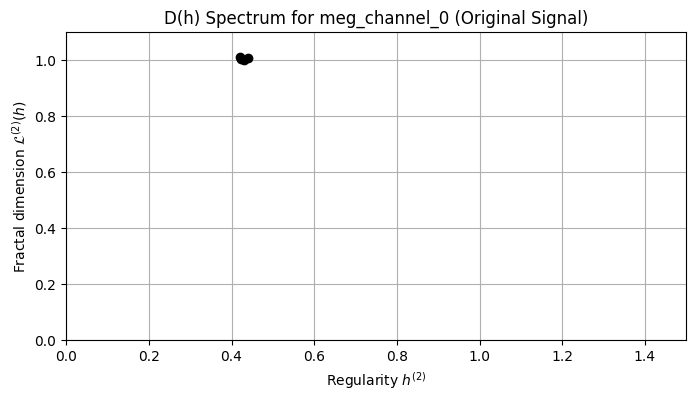

Processing signal: meg_channel_1


<Figure size 800x400 with 0 Axes>

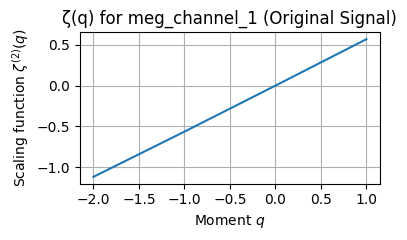

<Figure size 800x400 with 0 Axes>

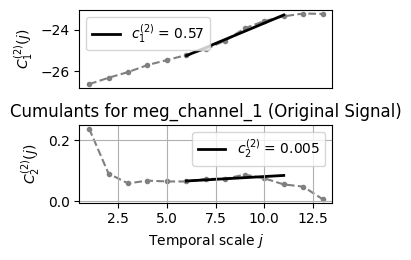

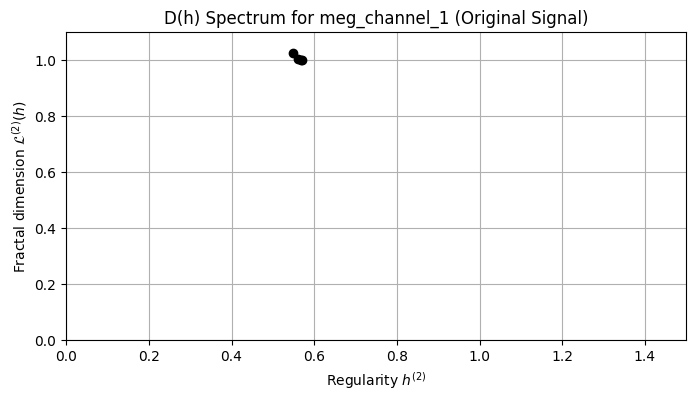

Processing signal: meg_channel_2


<Figure size 800x400 with 0 Axes>

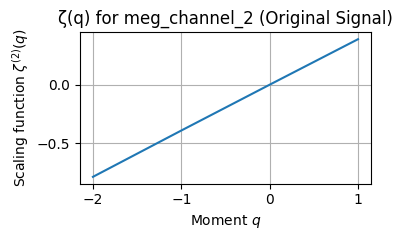

<Figure size 800x400 with 0 Axes>

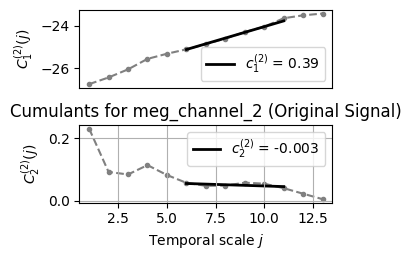

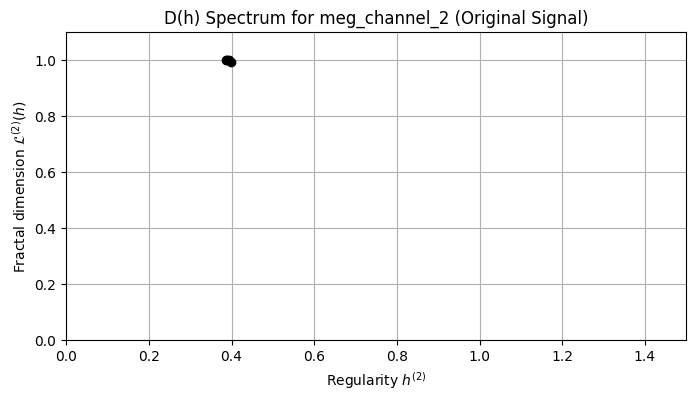

Processing signal: meg_channel_3


<Figure size 800x400 with 0 Axes>

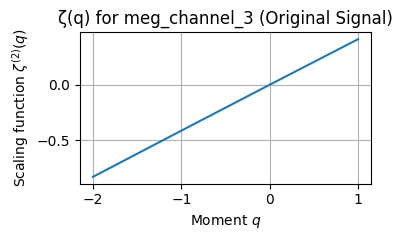

<Figure size 800x400 with 0 Axes>

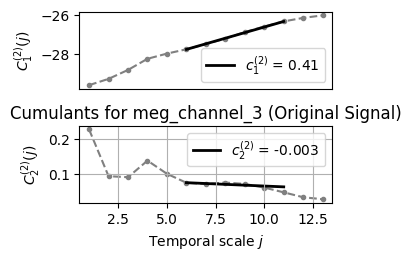

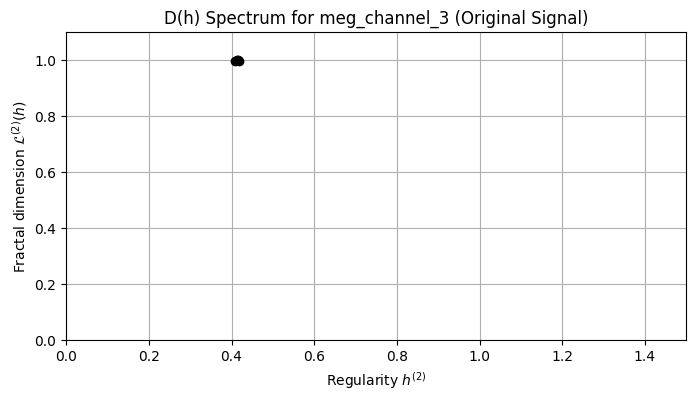

Processing signal: meg_channel_4


<Figure size 800x400 with 0 Axes>

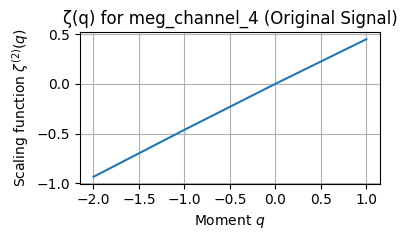

<Figure size 800x400 with 0 Axes>

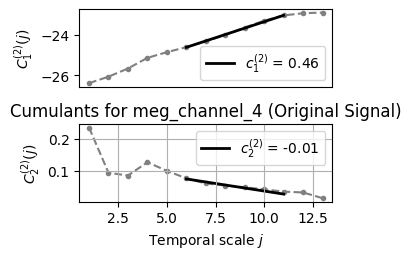

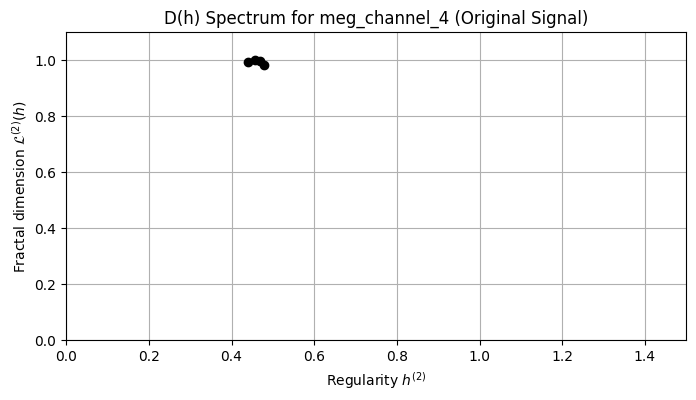

Processing signal: meg_channel_5


<Figure size 800x400 with 0 Axes>

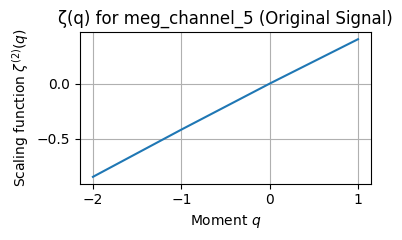

<Figure size 800x400 with 0 Axes>

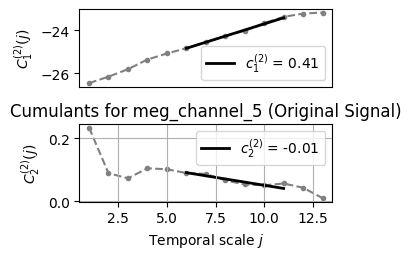

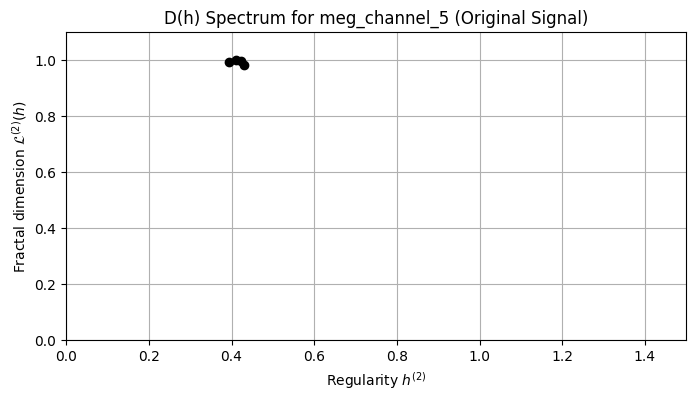

Processing signal: meg_channel_6


<Figure size 800x400 with 0 Axes>

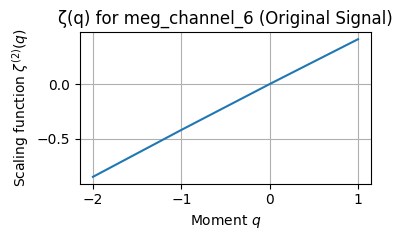

<Figure size 800x400 with 0 Axes>

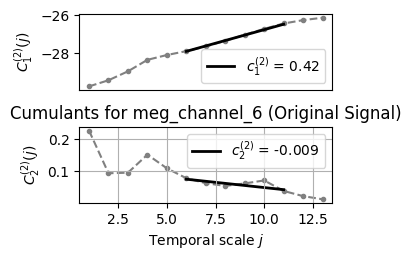

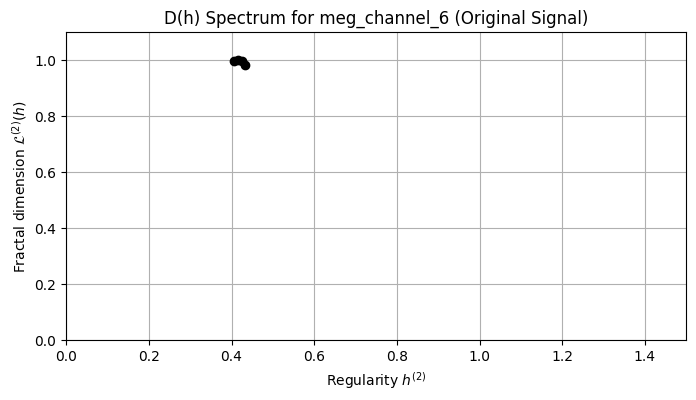

Processing signal: meg_channel_7


<Figure size 800x400 with 0 Axes>

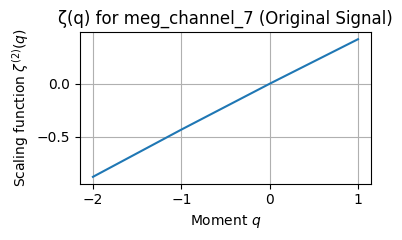

<Figure size 800x400 with 0 Axes>

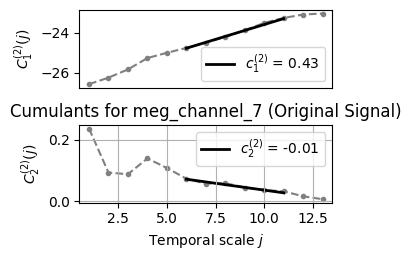

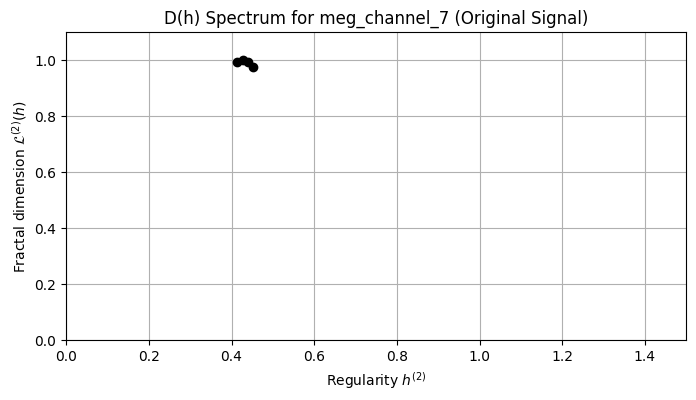

Processing signal: meg_channel_8


<Figure size 800x400 with 0 Axes>

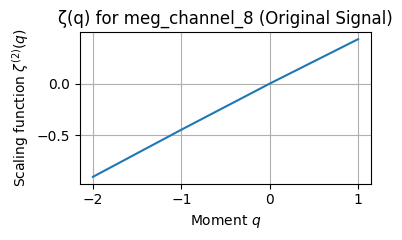

<Figure size 800x400 with 0 Axes>

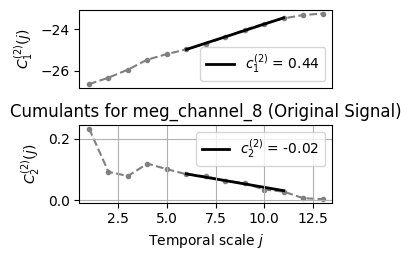

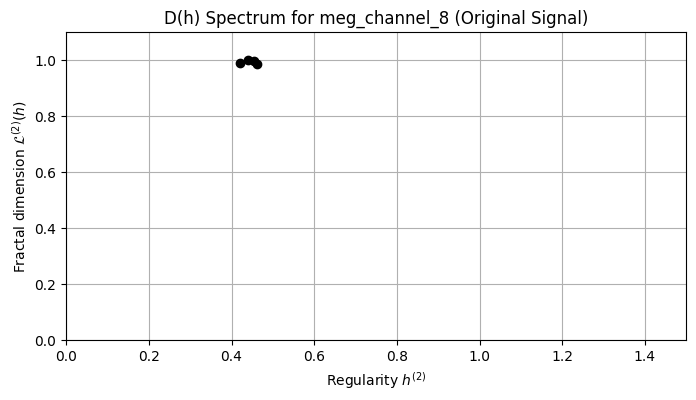

Processing signal: meg_channel_9


<Figure size 800x400 with 0 Axes>

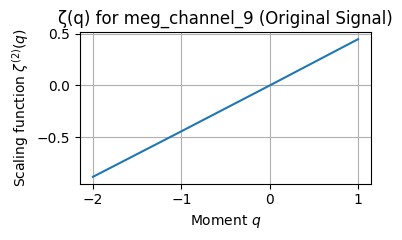

<Figure size 800x400 with 0 Axes>

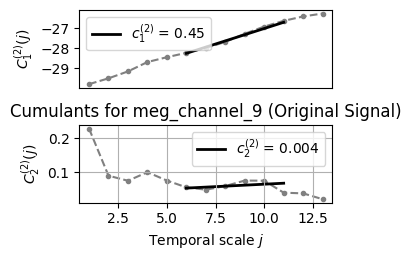

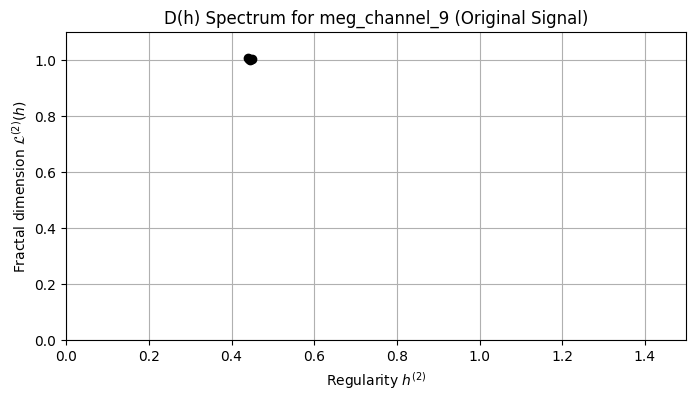

In [ ]:
scaling_ranges = [(6, 11)]
q_vals = np.arange(-2, 2)
summary_records = []
methods = ["VMD"]


signal_list = [data_matrix[ch_idx, :] for ch_idx in range(n_channels_to_process)]
signal_names = [f"meg_channel_{ch_idx}" for ch_idx in range(n_channels_to_process)]


for signal, name in zip(signal_list, signal_names):
    print(f"Processing signal: {name}")

    # MFA on original signal
    pwt_signal = compute_mfa(signal, scaling_ranges, q_vals)
    plot_mfa(pwt_signal, ch_label=f"{name} (Original Signal)")
    summary_records.append({
        "Signal": name,
        "Mode": "Original",
        "Log-cumulant 1": pwt_signal.cumulants.values[0],
        "Log-cumulant 2": pwt_signal.cumulants.values[1]

    })

    for method in methods:
        modes_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
        if not os.path.exists(modes_path):
            print(f"Modes not found for {name} / {method} at {modes_path}")
            continue

        modes = np.load(modes_path)
        print(f"Loaded modes shape: {modes.shape} for {name} / {method}")

        for idx, mode in enumerate(modes):
            pwt_mode = compute_mfa(mode, scaling_ranges, q_vals)
            #plot_mfa(pwt_mode, ch_label=f"{name} | {method} Mode {idx}")
            summary_records.append({
                "Signal": name,
                "Mode": f"{method} Mode {idx}",
                "Log-cumulant 1": pwt_mode.cumulants.values[0],
                "Log-cumulant 2": pwt_mode.cumulants.values[1]
            })

summary_df = pd.DataFrame(summary_records)
summary_df.to_csv(os.path.join(output_base, "mfa_log_cumulants_summary.csv"), index=False)


In [103]:
summary_df['C1_flat'] = summary_df['Log-cumulant 1'].apply(lambda arr: arr.flatten())
summary_df['C2_flat'] = summary_df['Log-cumulant 2'].apply(lambda arr: arr.flatten())

# Check the new columns
summary_df

,Signal,Mode,Log-cumulant 1,Log-cumulant 2,C1_flat,C2_flat
0,meg_channel_0,Original,"[[[-29.602716263113127]], [[-29.31714420502243...","[[[0.23107844912306064]], [[0.0905390461256274...","[-29.602716263113127, -29.317144205022434, -28...","[0.23107844912306064, 0.09053904612562746, 0.0..."
1,meg_channel_1,Original,"[[[-26.632769042210377]], [[-26.32331016613688...","[[[0.2380243922268619]], [[0.09043441583366985...","[-26.632769042210377, -26.32331016613688, -26....","[0.2380243922268619, 0.09043441583366985, 0.05..."
2,meg_channel_2,Original,"[[[-26.754338789383926]], [[-26.43815269437106...","[[[0.23160975464213607]], [[0.0923626449457515...","[-26.754338789383926, -26.43815269437106, -26....","[0.23160975464213607, 0.09236264494575153, 0.0..."
3,meg_channel_3,Original,"[[[-29.600312825628283]], [[-29.27875497000801...","[[[0.22677845672797048]], [[0.0932712993721907...","[-29.600312825628283, -29.27875497000801, -28....","[0.22677845672797048, 0.0932712993721907, 0.09..."
4,meg_channel_4,Original,"[[[-26.391888594459683]], [[-26.07152800240672...","[[[0.2359528943073883]], [[0.09367060402428251...","[-26.391888594459683, -26.07152800240672, -25....","[0.2359528943073883, 0.09367060402428251, 0.08..."
5,meg_channel_5,Original,"[[[-26.456191512475694]], [[-26.15505306581282...","[[[0.234499896149714]], [[0.08924672360114982]...","[-26.456191512475694, -26.155053065812826, -25...","[0.234499896149714, 0.08924672360114982, 0.072..."
6,meg_channel_6,Original,"[[[-29.778825093468583]], [[-29.45228477191572...","[[[0.2273296678171164]], [[0.09327419226201528...","[-29.778825093468583, -29.45228477191572, -28....","[0.2273296678171164, 0.09327419226201528, 0.09..."
7,meg_channel_7,Original,"[[[-26.57710102709813]], [[-26.25151113276623]...","[[[0.2359377924033197]], [[0.09337817495134004...","[-26.57710102709813, -26.25151113276623, -25.8...","[0.2359377924033197, 0.09337817495134004, 0.08..."
8,meg_channel_8,Original,"[[[-26.64754944140002]], [[-26.334243647534766...","[[[0.23286342051142128]], [[0.0918628190031540...","[-26.64754944140002, -26.334243647534766, -25....","[0.23286342051142128, 0.09186281900315407, 0.0..."
9,meg_channel_9,Original,"[[[-29.787243608197624]], [[-29.49705786568036...","[[[0.2285977707517759]], [[0.08930925421066149...","[-29.787243608197624, -29.497057865680365, -29...","[0.2285977707517759, 0.08930925421066149, 0.07..."
